In [1]:
import sys, os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table, join, hstack, vstack
import pywt
import h5py
sys.path.insert(1, '/home/luiz/IC/Codes/GMCA/gmca4im-master/scripts/')
import gmca4im_lib2 as g4i
from scipy import signal
from sklearn.decomposition import FastICA, PCA

In [2]:
######## Funções adicionais
######################################################################################################
######## Função para colocar média 0 nos mapas
def remove_mean(map_= None):
    len_nu_ch = np.shape(map_)[0]
    map_ = np.array([[map_[i] - np.mean(map_[i],axis=0)] for i in range(len_nu_ch)])
    return map_[ : , 0, : ]

def tanh(x):
    return np.tanh(x), (1/((np.cosh(x))**2)).mean(axis=-1)

######################################################################################################
def Filter(Ae=None, FG=False):
    W   = np.linalg.inv(np.dot(Ae.T,Ae))
    W   = np.dot(W,Ae.T) #Filter  
    if FG:
        return np.dot(Ae,W) #foreground filter
    else:
        return W

def Reconstruction_maps(X=None,Ae=None):
    X_fg = np.dot(Filter(Ae=Ae,FG=True),X)
    X_21 = X - X_fg
    return {"21cm":X_21,"foregrounds":X_fg}

def Residual_maps(X=None,Ae=None):
    X    = Reconstruction_maps(X,Ae)
    W_fg = Filter(Ae,True)
    R_21 = X["21cm"]        - np.dot(W_fg,X["21cm"])  
    R_fg = X["foregrounds"] - np.dot(W_fg,X["foregrounds"])  
    return {"21cm":R_21, "foregrounds":R_fg}
######################################################################################################

def Include_scalar_coefs(w,c,J=3):
    nbins,npix = c.shape

    for i in range(nbins):
        X = w[i].reshape(-1,J).T
        X = np.vstack((X,c[i]))
        X = X.T.flatten()
        if i==0:
            Xw_ = np.array(X)
        else:
            Xw_ = np.vstack((Xw_,X))
    return Xw_

/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_

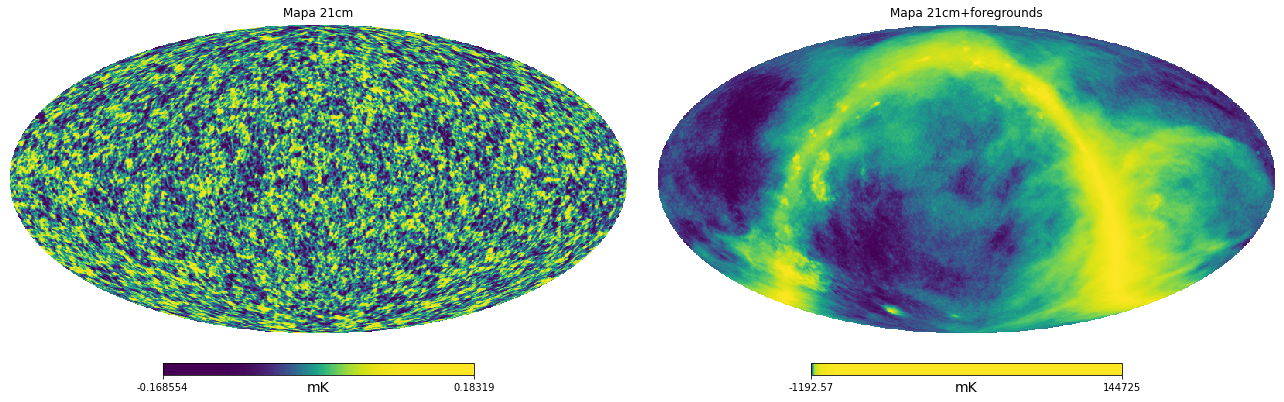

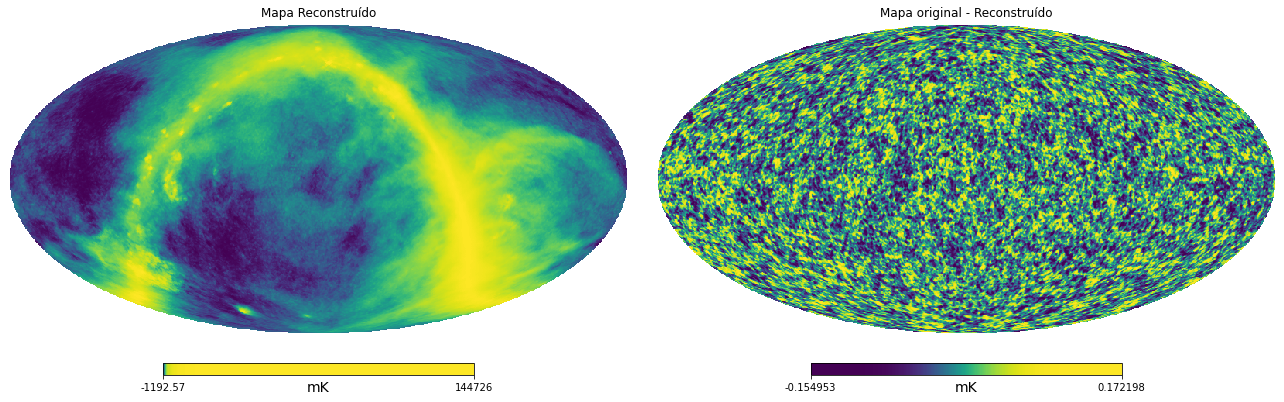

In [3]:
# fastICA sem wavelets
NSIDE = 2**8
######################################################################################################
######## Leitura dos arquivos
file_21cm = '/home/luiz/IC/Datas_Maps/Cube_21_L100_Smooth.fits' #Arquivo só com 21cm
with fits.open(file_21cm) as hdul1: 
    mapas_21cm = hdul1[0].data
    
file_mapas ='/home/luiz/IC/Datas_Maps/Cube_5PSM_L100_RS.fits' #Arquivo com tudo, foregrounds+21cm
with fits.open(file_mapas) as hdul2: 
    mapas = hdul2[0].data
    
######################################################################################################
######## Média 0 nos mapas
mapas = remove_mean(mapas)
mapas_21cm = remove_mean(mapas_21cm)


######################################################################################################        
######## algoritmo fastICA
ica = FastICA(n_components=5, max_iter = 10000, tol=1e-7, fun = tanh
S_ = ica.fit_transform(Xw_.T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
              
              
W = np.linalg.inv(A_.T @ A_) @ A_.T    #penrose moore inverse
S = W @ mapas
mapa_reconstruido = A_ @ S

              
              
######################################################################################################
######## Visualização dos mapas lidos
mapa_plot = [mapas_21cm[13], mapas[13]] #vetor com os mapas
titulos = ["Mapa 21cm", "Mapa 21cm+foregrounds"] #vetor com os nomes
plt.figure(figsize = (18,8))
for i in range(2):
        hp.mollview(mapa_plot[i], sub=(1,2,i+1), norm='hist', title=titulos[i], unit='mK' )

######################################################################################################   
########Visualização do mapa reconstruido, e do que foi filtrado que deve ser igual ao 21cm
mapa_plot = [mapa_reconstruido[13], mapas[13] - mapa_reconstruido[13]] #vetor com os mapas
titulos = ["Mapa Reconstruído", "Mapa original - Reconstruído"] #vetor com os nomes
plt.figure(figsize = (18,8))
for i in range(2):
        hp.mollview(mapa_plot[i], sub=(1,2,i+1), norm='hist', title=titulos[i], unit='mK' )
######################################################################################################

In [21]:
mapa_rec = Reconstruction_maps(mapas, A_)
mapa_rec['21cm']

array([[-0.00955969, -0.0006236 , -0.01316716, ..., -0.0185371 ,
        -0.04514701, -0.02401406],
       [ 0.05489103,  0.05254139,  0.04164118, ...,  0.00891308,
         0.01969874,  0.02442463],
       [-0.00352644, -0.00144442,  0.00282181, ...,  0.01430585,
         0.02137141, -0.00479844],
       ...,
       [-0.02999971, -0.04019446, -0.02707649, ...,  0.04578557,
         0.04333347,  0.03382656],
       [-0.02462911, -0.03500285, -0.02337851, ...,  0.03323595,
         0.03211192,  0.02635271],
       [-0.01548078, -0.02081035, -0.01508452, ...,  0.02385912,
         0.02869936,  0.02415654]])

In [4]:
######## Verificação do formato das matrizes
######################################################################################################
#print(hdul1.info())   
#print(hdul2.info())  
print('21cm',mapas_21cm.shape,'21cm+foregrounds', mapas.shape)
print('S_', S_.shape,'A_' , A_.shape,'W' , W.shape,'S' , S.shape)
print('Mapa reconstruido', mapa_reconstruido.shape)
######################################################################################################

21cm (30, 786432) 21cm+foregrounds (30, 786432)
S_ (786432, 5) A_ (30, 5) W (5, 30) S (5, 786432)
Mapa reconstruido (30, 786432)


In [17]:
######## Verificação do tamanho do erro da reconstrução
######################################################################################################
print('diferença:         ',np.var((mapas[13]-mapa_reconstruido[13])- mapas_21cm[13]))
print('21cm:              ',np.var(mapas_21cm[13]))
print('21cm reconstruido: ',np.var((mapas[13]-mapa_reconstruido[13])))


print((100*np.var((mapas[13]-mapa_reconstruido[13])- mapas_21cm[13]))/np.var((mapas[13]-mapa_reconstruido[13])),'%')
######################################################################################################

diferença:          0.00012168527709737884
21cm:               0.001600618344545846
21cm reconstruido:  0.0014734331676018238
[-0.1949815  -0.23656583 -0.20842947 ...  0.88752427  1.00931122
  0.43100181] %
8.258622092472313 %


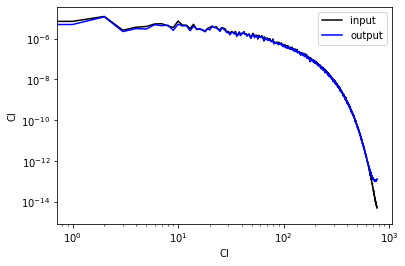

In [18]:
######## Verificação de erro
######################################################################################################
cl_input = hp.anafast(mapas_21cm[13])
cl_output = hp.anafast(mapas[13]- mapa_reconstruido[13])
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Cl')
plt.ylabel('Cl')
plt.legend()


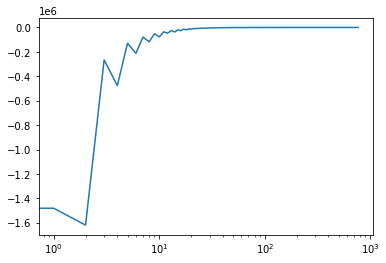

In [7]:
plt.plot(cl_input - cl_output)
plt.xscale('log')

/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


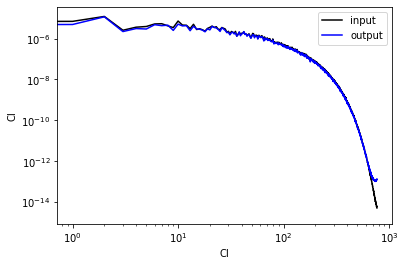

In [8]:
### ?????????????????????????
### Funções do Alessandro
######################################################################################################
ica = FastICA(n_components=5, max_iter = 1000, tol=1e-7)
S_ = ica.fit_transform(mapas.T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
mapas_rec = Reconstruction_maps(mapas, A_)
cl_input = hp.anafast(mapas_21cm[13])
cl_output = hp.anafast(mapas_rec['21cm'][13])
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Cl')
plt.ylabel('Cl')
plt.legend()
### /???????????????????????????????????? pq o plot fica melhor?
######################################################################################################

In [25]:
######## Verificação do tamanho do erro da reconstrução
## ???????????????????/ pq mesmo com o plot melhor o erro parece maior?
######################################################################################################
print('diferença:         ',np.var(mapas_rec['21cm'][13]- mapas_21cm[13]))
print('21cm:              ',np.var(mapas_21cm[13]))
print('21cm reconstruido: ',np.var(mapas_rec['21cm'][13]))
print(100*np.var(mapas_rec['21cm'][13]- mapas_21cm[13]/(mapas_21cm[13])))
print((100*np.var(mapas_rec['21cm'][13]- mapas_21cm[13]))/np.var(mapas_rec['21cm'][13]),'%')
######################################################################################################

diferença:          0.00012168721125329967
21cm:               0.001600618344545846
21cm reconstruido:  0.0014734331719061268
0.1473433171906127
8.258753337002544 %


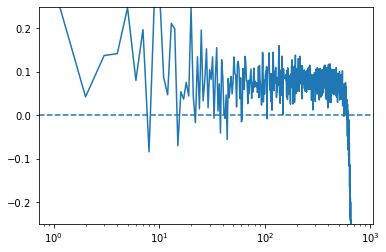

In [30]:
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')


In [11]:
# fastICA com wavelets
NSIDE = 2**8
######################################################################################################








######################################################################################################

/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


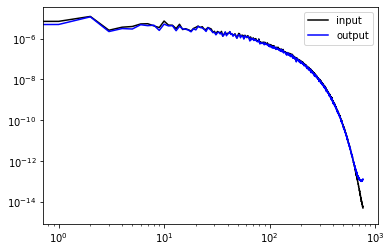

In [12]:
### ?????????????????????????
### Funções do Alessandro
######################################################################################################
ica = FastICA(n_components=5, max_iter = 10000, tol=1e-7)
S_ = ica.fit_transform(mapas.T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
mapas_rec = Reconstruction_maps(mapas, A_)
cl_input = hp.anafast(mapas_21cm[13])
cl_output = hp.anafast(mapas_rec['21cm'][13])
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
### /???????????????????????????????????? pq o plot fica melhor?
######################################################################################################

In [13]:
######## Verificação do tamanho do erro da reconstrução
## ???????????????????/ pq mesmo com o plot melhor o erro parece maior?
######################################################################################################
print('diferença:         ',np.var(mapas_rec['21cm'][13]- mapas_21cm[13]))
print('21cm:              ',np.var(mapas_21cm[13]))
print('21cm reconstruido: ',np.var(mapas_rec['21cm'][13]))
print((100*np.var(mapas_rec['21cm'][13]- mapas_21cm[13]))/np.var(mapas_21cm[13]),'%')
print((100*np.var(mapas_rec['21cm'][13]- mapas_21cm[13]))/np.var(mapas_rec['21cm'][13]),'%')
######################################################################################################

diferença:          0.00012167936385919584
21cm:               0.001600618344545846
21cm reconstruido:  0.0014734331825971957
7.602022323049204 %
8.258220684613175 %


/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


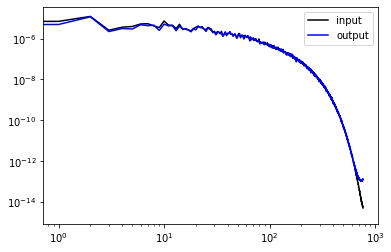

In [14]:
### ?????????????????????????
### Funções do Alessandro
######################################################################################################
ica = FastICA(n_components=5, max_iter = 10000, tol=1e-7, fun = tanh)
S_ = ica.fit_transform(mapas.T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
mapas_rec = Reconstruction_maps(mapas, A_)
cl_input = hp.anafast(mapas_21cm[13])
cl_output = hp.anafast(mapas_rec['21cm'][13])
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
### /???????????????????????????????????? pq o plot fica melhor?
######################################################################################################

In [15]:
####### Verificação do tamanho do erro da reconstrução
## ???????????????????/ pq mesmo com o plot melhor o erro parece maior?
######################################################################################################
print('diferença:         ',np.var(mapas_rec['21cm'][13]- mapas_21cm[13]))
print('21cm:              ',np.var(mapas_21cm[13]))
print('21cm reconstruido: ',np.var(mapas_rec['21cm'][13]))
print((100*np.var(mapas_rec['21cm'][13]- mapas_21cm[13]))/np.var(mapas_21cm[13]),'%')
print((100*np.var(mapas_rec['21cm'][13]- mapas_21cm[13]))/np.var(mapas_rec['21cm'][13]),'%')
######################################################################################################
0.00012167936385919584

diferença:          0.00012168721125329967
21cm:               0.001600618344545846
21cm reconstruido:  0.0014734331719061268
7.602512595707305 %
8.258753337002544 %
